## Xtractomaticpy

A Notebook for loading in environmental data, transforming it into points and into a `pandas` df, and combining it with the tag data.

In [3]:
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
from typing import Dict, Union
import fsspec
import matplotlib.pyplot as plt
from datetime import datetime 

{'latitude': slice(24.44818354, 35.90428483, None),
 'longitude': slice(-82.06428163, -71.04951667, None)}

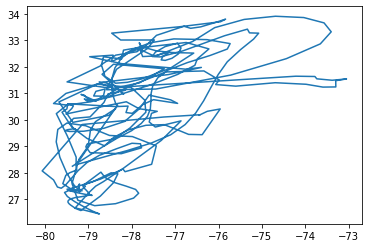

In [4]:
shark_dir = "track_shark144020.csv"
track_ex = pd.read_csv(shark_dir, parse_dates=['datetime']) # in pandas, read_csv

# track_ex["lon"] = np.where(
#     track_ex["lon"] < 180,
#     track_ex["lon"] + 360,
#     track_ex["lon"])

lat_min = track_ex["lat"].min() - 2.0
lat_max = track_ex["lat"].max() + 2.0
lon_min = track_ex["lon"].min() - 2.0
lon_max = track_ex["lon"].max() + 2.0

xy_bbox = dict(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))

plt.plot(track_ex.lon,track_ex.lat)

xy_bbox

In [17]:
track_ex

,lon,lat,datetime
0,-78.984392,27.187935,2014-11-15
1,-78.952825,27.172386,2014-11-16
2,-78.924598,27.156750,2014-11-17
3,-78.912462,27.146158,2014-11-18
4,-78.929166,27.145738,2014-11-19
...,...,...,...
367,-78.001361,29.588447,2016-02-27
368,-78.335888,29.305051,2016-02-28
369,-78.677138,28.971130,2016-02-29
370,-79.021606,28.612226,2016-03-01


In [9]:
# grab track data for a few tag datapoints
track_2014 = track_ex.iloc[0:100]
track_2014

,lon,lat,datetime
0,-78.984392,27.187935,2014-11-15
1,-78.952825,27.172386,2014-11-16
2,-78.924598,27.156750,2014-11-17
3,-78.912462,27.146158,2014-11-18
4,-78.929166,27.145738,2014-11-19
...,...,...,...
95,-78.723525,27.119560,2015-03-02
96,-78.421479,27.623690,2015-03-03
97,-78.320163,27.959357,2015-03-04
98,-78.473697,27.999699,2015-03-05


# load in environmental data
here is the SST from MUR

In [6]:
# bring in data for SST
file_location = 's3://mur-sst/zarr'
ikey = fsspec.get_mapper(file_location, anon=True)
ds_sst = xr.open_zarr(ikey,consolidated=True)
ds_sst

,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


here is the SSH and velocity from CMEMS

In [7]:
ds_ssh = xr.open_dataset("data/ssh_data.nc")
# Converting the lat lon to -180 180
with xr.set_options(keep_attrs=True):
    ds_ssh = ds_ssh.assign({'longitude':(((ds_ssh.longitude + 180) % 360) - 180)})

ds_ssh_renamed = ds_ssh.rename({'latitude':'lat', 'longitude':'lon', 'time':'time'})
ds_ssh_renamed

<xarray.Dataset>
Dimensions:  (time: 2224, lat: 41, lon: 48)
Coordinates:
  * time     (time) datetime64[ns] 2014-05-01 2014-05-02 ... 2020-06-01
  * lat      (lat) float32 25.12 25.38 25.62 25.88 ... 34.38 34.62 34.88 35.12
  * lon      (lon) float32 -81.88 -81.62 -81.38 -81.12 ... -70.62 -70.38 -70.12
Data variables:
    adt      (time, lat, lon) float64 ...
    ugos     (time, lat, lon) float64 ...
    vgos     (time, lat, lon) float64 ...
    vgosa    (time, lat, lon) float64 ...
    err      (time, lat, lon) float64 ...
    sla      (time, lat, lon) float64 ...
    ugosa    (time, lat, lon) float64 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2020-06-03T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2020-06-03T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    History:                         Translated to CF-1.0 Conventions by Netc...

here is the Ocean Color data from MODISA, accessed via OpenDap

In [15]:
# calculate year day for time range of tagged data
day_list = []
year_list = []
for index, row in track_2014.iterrows():
    row_time = pd.to_datetime(row["datetime"])
    day_of_year = datetime(row_time.year, row_time.month, row_time.day).timetuple().tm_yday
    year_list.append(row_time.year)
    day_list.append(day_of_year)
day_string = [str(x) for x in day_list]
year_string = [str(x) for x in year_list]

# create access url for ocean color on opendap, merge datafiles to xarray
url = []
base_dir = 'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/'
suffix = '.L3m_DAY_CHL_chlor_a_4km.nc'

k = 0
for day in day_string:
    url.append('https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/' + year_string[k] +'/' + day + '/A'+year_string[k] + day + '.L3m_DAY_CHL_chlor_a_4km.nc')
    k = k+1

def add_id(ds):
    ds.coords['time_coverage_start'] = pd.to_datetime(ds.attrs['time_coverage_start'])
    return ds

chl = xr.open_mfdataset(url, combine = 'nested', concat_dim='time_coverage_start', preprocess=add_id)
chl = chl.sel( lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max)) # these data have the lat indexed backwards... no idea why, but it works this way
chl

<xarray.Dataset>
Dimensions:              (lat: 275, lon: 265, time_coverage_start: 10, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat                  (lat) float32 35.9 35.85 35.81 ... 24.56 24.52 24.48
  * lon                  (lon) float32 -82.06 -82.02 -81.98 ... -71.1 -71.06
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2014-11-15T00:0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    palette              (time_coverage_start, rgb, eightbitcolor) int8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
    chlor_a              (time_coverage_start, lat, lon) float32 dask.array<chunksize=(1, 275, 265), meta=np.ndarray>
Attributes: (12/65)
    _NCProperties:                     version=1|netcdflibversion=4.4.1.1|hdf...
    product_name:                      A2014319.L3m_DAY_CHL_chlor_a_4km.nc
    instrument:                        MODIS
    title:                             HMODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2116283
    data_minimum:                      0.008335022
    data_maximum:                      99.91856

In [10]:
# extraction and combining here
# for each environmental data set, change the object name in the envdata_point() function


def fuction_dataset_point(**kwargs) -> Dict[str, Union[float, int]]:
    pass




def extract(function_dataset_point, 
            df: pd.DataFrame, 
            map_coordinates: Dict[str, str], 
            rename_variables: Dict[str, str]) -> pd.DataFrame:
    """
    function_dataset_point: environmental data in a point format, to be transformed
    df tag data in a pandas format
    map_coordinates: key is name of column in dataframe, value is the name of the coordinate in dataset
    rename_variables: TBD
    """
    
    def get_row(row) -> Dict[str, Union[float, int]]:
        extract_coordinates = {}
        
        for key, val in map_coordinates.items():
            extract_coordinates[val] = row[key]
        
        result = function_dataset_point(**extract_coordinates)
        
        # rename variables here and transform result
        return result
    
    return df.apply(
        lambda row: get_row(row), axis=1, result_type="expand"
    )



# CHANGE YOUR ENVIRONMENTAL DATA SOURCE HERE
def ssh_point(lat, lon, time) -> Dict[str, Union[float, int]]: # change variable here
    ds = ds_ssh_renamed.sel(lat=lat, lon=lon, time=time, method="nearest") # change variable here

    results = {}
    
    for var in ds.variables:
        if var not in ds.coords:
            results[var] = ds[var].values
    
    return results

result = pd.concat([track_2014, 
                    extract(ssh_point, # change variable here
                            track_2014, 
                            {"lat": "lat", "lon": "lon", "datetime": "time"}, # change variable here, df : ds
                            {}
                           )
                   ], axis=1)
result # sst in Kelvin?


,lon,lat,datetime,adt,ugos,vgos,vgosa,err,sla,ugosa
0,-78.984392,27.187935,2014-11-15,0.7547,-0.1131,-0.13040000000000002,-0.1345,0.030100000000000002,0.07440000000000001,-0.09190000000000001
1,-78.952825,27.172386,2014-11-16,0.761,-0.11610000000000001,-0.1199,-0.124,0.031400000000000004,0.08070000000000001,-0.09480000000000001
2,-78.924598,27.156750,2014-11-17,0.7579,-0.1178,-0.1067,-0.11080000000000001,0.033,0.0776,-0.0965
3,-78.912462,27.146158,2014-11-18,0.7619,-0.0891,-0.052000000000000005,-0.0562,0.032100000000000004,0.0816,-0.0678
4,-78.929166,27.145738,2014-11-19,0.7529,-0.0526,-0.0374,-0.0415,0.0327,0.0726,-0.0313
...,...,...,...,...,...,...,...,...,...,...
95,-78.723525,27.119560,2015-03-02,0.5899,-0.1388,-0.2722,-0.29450000000000004,0.024,-0.0825,-0.12560000000000002
96,-78.421479,27.623690,2015-03-03,0.5385,0.08710000000000001,-0.3447,-0.3271,0.0199,-0.10890000000000001,0.0422
97,-78.320163,27.959357,2015-03-04,0.5426,-0.06470000000000001,-0.3584,-0.37160000000000004,0.0207,-0.1135,0.0165
98,-78.473697,27.999699,2015-03-05,0.5342,-0.0456,-0.3169,-0.3302,0.021,-0.12190000000000001,0.0356


In [11]:
result.to_csv('ssh_matched.csv')

In [13]:
result['mag'] = (result['ugos']**2 + result[vgos**2) ** 0.5
result

/tmp/ipykernel_1613/354212438.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.mag = (result.ugos**2 + result.vgos**2) ** 0.5


,lon,lat,datetime,adt,ugos,vgos,vgosa,err,sla,ugosa
0,-78.984392,27.187935,2014-11-15,0.7547,-0.1131,-0.13040000000000002,-0.1345,0.030100000000000002,0.07440000000000001,-0.09190000000000001
1,-78.952825,27.172386,2014-11-16,0.761,-0.11610000000000001,-0.1199,-0.124,0.031400000000000004,0.08070000000000001,-0.09480000000000001
2,-78.924598,27.156750,2014-11-17,0.7579,-0.1178,-0.1067,-0.11080000000000001,0.033,0.0776,-0.0965
3,-78.912462,27.146158,2014-11-18,0.7619,-0.0891,-0.052000000000000005,-0.0562,0.032100000000000004,0.0816,-0.0678
4,-78.929166,27.145738,2014-11-19,0.7529,-0.0526,-0.0374,-0.0415,0.0327,0.0726,-0.0313
...,...,...,...,...,...,...,...,...,...,...
95,-78.723525,27.119560,2015-03-02,0.5899,-0.1388,-0.2722,-0.29450000000000004,0.024,-0.0825,-0.12560000000000002
96,-78.421479,27.623690,2015-03-03,0.5385,0.08710000000000001,-0.3447,-0.3271,0.0199,-0.10890000000000001,0.0422
97,-78.320163,27.959357,2015-03-04,0.5426,-0.06470000000000001,-0.3584,-0.37160000000000004,0.0207,-0.1135,0.0165
98,-78.473697,27.999699,2015-03-05,0.5342,-0.0456,-0.3169,-0.3302,0.021,-0.12190000000000001,0.0356
